This is a sequel to "Plot_Tests.ipynb", which has become messy to the point of inconvenience. To save myself time, I will attempt to clean things up on this new notebook.
-- Julia Buhrman (11/15/2023)

(01/04/2024) I realized that coniglio and parker actually literally wrote how they determined storm motion in the paper and I had just missed it this whole time. I was pretty close, just need to do the weighted averages with time:
"The motion of each supercell at each volume time was determined in two steps: first, a five-point (20–25 min) weighted average of instantaneous storm-motion components (using weights of 0.05, 0.2, 0.5, 0.2, and 0.05) was computed. The instantaneous storm motions were based on the bearing and great circle distance between successive latitude and longitude points assigned to the updraft." (Coniglio and Parker 2020)

At this point, I want to plot the great circle distance from the vads to the storm and the bearing of the vads on a polar plot.

In [1]:
# import necessary stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import coords
import xarray as xr
import pyart
from datetime import timedelta
from radarcalc import *
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy
import metpy.plots
from metpy.units import units
import cartopy.crs as ccrs
import cartopy
import gc


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\julia\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\julia\Desktop\Research\radarcalc.py:81: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [2]:
# bring in the data, in this case it's from Morton

# gps data for first ka
ka1gps = pd.read_csv('C:/Users/julia/Desktop/Research/GPS_Ka1_20220523.txt')
# scan data for first ka
ka1scan = pd.read_csv('C:/Users/julia/Desktop/Research/20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])

# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska1 = sorted(glob.glob('C:/Users/julia/Desktop/Research/product_raw_ka1/*.nc'))

# sanity checks to make sure they're loading in:
#print(vad_fileska1)
#print(ka1gps)

Now that the data is loaded in, we need to create a function that converts the distance from the storm to the vehicle from (lat,lon) into meters.

In [3]:
#Read in storm location csv

storm_location = pd.read_csv(r"C:\Users\julia\Desktop\Research\StormLocationMorton.csv", header=0)
storm_location['Date']=storm_location['Date'].astype(str).str.zfill(8)
storm_location['Time']=storm_location['Time'].astype(str).str.zfill(8)
storm_location['datetime'] = pd.to_datetime(storm_location['Date'].astype(str)+storm_location['Time'].astype(str),format='%m/%d/%Y%H:%M:%S')

storm_location['Lon'] = storm_location['Lon'].astype(str).str.zfill(8)
storm_lon = storm_location['Lon'].astype(float) # .astype(float) changes it from string to float since you cant operate on strings

print(storm_lon)

storm_location['Lat'] = storm_location['Lat'].astype(str).str.zfill(8) 
storm_lat = storm_location['Lat'].astype(float)

print(storm_lat)
#print(storm_location)

0    -103.098
1    -103.073
2    -103.061
3    -103.058
4    -103.054
       ...   
59   -102.204
60   -102.155
61   -102.119
62   -102.105
63   -102.067
Name: Lon, Length: 64, dtype: float64
0     33.497
1     33.510
2     33.522
3     33.553
4     33.584
       ...  
59    33.650
60    33.650
61    33.650
62    33.650
63    33.650
Name: Lat, Length: 64, dtype: float64


!! Maybe the issue is that I'm using storm location and not the location of the mesocyclone?
I'm not sure which feature of the storm is being tracked to determine its location

In [4]:
#  function that will convert distance from (lat1, lon1) to (lat2, lon2) into meters
def coordinates_to_meters(lat1, lat2, lon1, lon2):
    d=2*np.arcsin(np.sqrt((np.sin((lat1-lat2)/2))**2 + np.cos(lat1)*np.cos(lat2)*(np.sin((lon1-lon2)/2))**2)) 
    return d

Maybe my formula was wrong for coords to meters? New attempt:

In [5]:
def new_coordinates_to_meters(lat1, lat2, lon1, lon2):
    r = 6378.137 # radius of earth in km
    d=2*np.arcsin(np.sqrt((np.sin((lat1-lat2)/2))**2 + np.cos(lat1)*np.cos(lat2)*(np.sin((lon1-lon2)/2))**2))
    new_d = d * r
    #d_meters = new_d * 1000 # converts to meters 
    #d_meters = d * 1000 
    return new_d

In [6]:
# from stackoverflow (https://stackoverflow.com/questions/639695/how-to-convert-latitude-or-longitude-to-meters)
# originally in javascript
def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180;
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180;
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    #d_meters = d * 1000
    return d # km

In [35]:
def haversine(lat1, lon1, lat2, lon2): 
    R = 6378 # km
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = ((np.sin(dlat/2))**2) + np.cos(lat1) * np.cos(lat2) * ((np.sin(dlon/2))**2)
    c = 2 * np.arcsin(min(1,np.sqrt(a)))
    d = R * c # d will be in same units as R
    return c

In [8]:
# example on how to grab lat and lon, these are from the gps

lat=ka1gps.Latitude # <== easier way to grab column
lon=ka1gps.Longitude
print(lat)
print(lon)

0        33.588547
1        33.588547
2        33.588547
3        33.588547
4        33.588547
           ...    
31901    33.589625
31902    33.589630
31903    33.589645
31904    33.589662
31905    33.589678
Name: Latitude, Length: 31906, dtype: float64
0       -102.031783
1       -102.031783
2       -102.031783
3       -102.031783
4       -102.031783
            ...    
31901   -102.032235
31902   -102.032227
31903   -102.032210
31904   -102.032200
31905   -102.032198
Name: Longitude, Length: 31906, dtype: float64


In [9]:
# however, we dont want these, we want only the lat and lons from every vad position
# from alex's code though, he accesses these files to get lat and lon so i guess its what we want?
# all of the data is from when the stuff was collected??

**!!!MAKE SURE TO CHECK WHICH INPUTS GO WHERE FOR EACH FUNCTION!!!**

In [38]:
# to iterate through the files, we need a loop with the function inside:

# dfs: Distance From Storm (in meters?)
dfs = []
for i in np.arange(0,len(storm_location)):
    cms = coordinates_to_meters(lat[i], storm_lat[i], lon[i], storm_lon[i])
    dfs.append(cms)

In [11]:
print(dfs)

[0.5491382184331255, 0.5415288702450524, 0.5396866024354493, 0.549116572006649, 0.5592960803280762, 0.56906999520701, 0.5773251679602474, 0.5703122394355856, 0.5757010534828599, 0.5690986377100071, 0.5783958114093755, 0.5893559332693744, 0.5885471264140699, 0.5773677442971304, 0.5865695896401191, 0.5801969694643064, 0.5945601773074174, 0.607440313337128, 0.614099992036913, 0.6154629041393711, 0.6154597323901363, 0.5953657907262988, 0.5782554022263697, 0.5720721283265771, 0.5720685144132972, 0.5720665850020366, 0.5720629712734195, 0.5720613156272608, 0.5720579755688245, 0.563081844426304, 0.5429283452928845, 0.5096573175886764, 0.503194532468068, 0.5031888270783327, 0.4921387832822447, 0.4921333532867246, 0.4716109128785553, 0.4669797942654207, 0.45743571361955687, 0.457430920203666, 0.44620186941608647, 0.4320906183808657, 0.413053159316196, 0.4002354822859825, 0.390779575095241, 0.3714224251096344, 0.3419628487543061, 0.31047934666830007, 0.29429796308797607, 0.25999252205144757, 0.23

In [12]:
dfs_new = []
for i in np.arange(0,len(storm_location)):
    cms_new = new_coordinates_to_meters(lat[i], storm_lat[i], lon[i], storm_lon[i])
    dfs_new.append(cms_new)

In [13]:
print(dfs_new)

[3502.4787891024, 3453.9453238781675, 3442.195087397829, 3502.340725228772, 3567.2670238954747, 3629.6063920196525, 3682.259014798468, 3637.5295958969677, 3671.9001901580077, 3629.7890778277915, 3689.0877253951594, 3758.9928841549277, 3753.8342032252567, 3682.5305725080666, 3741.22120275846, 3700.575758228163, 3792.1862656109993, 3874.3375377871293, 3916.8138809103402, 3925.506721018776, 3925.4864911676264, 3797.324578365663, 3688.192176389891, 3648.754408348489, 3648.731358314484, 3648.7190522651345, 3648.6960034089343, 3648.6854434709103, 3648.6641401206157, 3591.4131459636533, 3462.8713674613223, 3250.6641946330874, 3209.443665732286, 3209.4072759749156, 3138.928582787466, 3138.8939495321297, 3007.99901303449, 2978.4611040566674, 2917.5876501582993, 2917.5570770950494, 2845.936652791909, 2755.9331604478793, 2634.509638401524, 2552.7567382810694, 2492.4456667592353, 2368.983112221488, 2181.0858982652435, 1980.2798087209114, 1877.0727273960542, 1658.2679246196535, 1523.8272253686441, 

In [41]:
dfs_new2 = []
for i in np.arange(0,len(storm_location)):
    cms_new2 = measure(lat[i], lon[i], storm_lat[i], storm_lon[i])
    dfs_new2.append(cms_new2)

In [42]:
print(dfs_new2)

[99.44866228518941, 96.99327591574487, 95.76539347457125, 95.26527970375814, 94.79638699632507, 94.17502958517098, 94.16193970516501, 91.09890630089303, 89.8471512797876, 87.21665881499949, 87.0826126899915, 87.14100531187202, 86.16409071545417, 84.10508516038153, 83.6494269009127, 82.18243739231421, 82.76768093934197, 83.32566794529853, 83.45054756294712, 83.53147427194537, 83.53067165800631, 81.59929924740943, 79.1014475684909, 78.15360957547108, 78.1528498178964, 78.15234814710408, 78.15158841130109, 78.15116988778388, 78.15049329259767, 76.77555691868567, 73.9959325202068, 69.13816174725719, 68.32543589953806, 68.32442419208635, 67.16221449339952, 67.16125708011887, 65.60633522263349, 65.0075353994268, 63.585373188805434, 63.58453249334351, 62.3144158094225, 60.29397057166209, 58.377210807072096, 56.42696096760595, 55.0018719583857, 52.07638699092252, 48.73712743348662, 45.776852532371095, 43.93251885894305, 39.439075573270735, 36.61515318745132, 33.00864945485216, 31.2402368154862

In [86]:
np.shape(dfs_new2)

(64,)

In [39]:
dfs_new3 = []
for i in np.arange(0,len(storm_location)):
    cms_new3 = haversine(lat[i], lon[i], storm_lat[i], storm_lon[i])
    dfs_new3.append(cms_new3)

In [40]:
print(dfs_new3)

[0.5491382184331255, 0.5415288702450524, 0.5396866024354493, 0.549116572006649, 0.5592960803280762, 0.56906999520701, 0.5773251679602474, 0.5703122394355856, 0.5757010534828599, 0.5690986377100071, 0.5783958114093755, 0.5893559332693744, 0.5885471264140699, 0.5773677442971304, 0.5865695896401191, 0.5801969694643064, 0.5945601773074174, 0.607440313337128, 0.614099992036913, 0.6154629041393711, 0.6154597323901363, 0.5953657907262988, 0.5782554022263697, 0.5720721283265771, 0.5720685144132972, 0.5720665850020366, 0.5720629712734195, 0.5720613156272608, 0.5720579755688245, 0.563081844426304, 0.5429283452928845, 0.5096573175886764, 0.503194532468068, 0.5031888270783327, 0.4921387832822447, 0.4921333532867246, 0.4716109128785553, 0.4669797942654207, 0.45743571361955687, 0.457430920203666, 0.44620186941608647, 0.4320906183808657, 0.413053159316196, 0.4002354822859825, 0.390779575095241, 0.3714224251096344, 0.3419628487543061, 0.31047934666830007, 0.29429796308797607, 0.25999252205144757, 0.23

Now that we have our distance from the storm in meters-- aka our r -- we need theta.
Theta is the bearing from the VADs.

In [17]:
bearing_list = []

# Code from Alex S and Josh O
# Fixing the bearing
from datetime import datetime

# gps data for first ka
ka1gps = pd.read_csv('C:/Users/julia/Desktop/Research/GPS_Ka1_20220523.txt')
ka1gps=ka1gps.astype(str)
# scan data for first ka
ka1scan = pd.read_csv('C:/Users/julia/Desktop/Research/20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])
# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska1 = sorted(glob.glob('C:/Users/julia/Desktop/Research/product_raw_ka1/*.nc'))

#print(ka1gps)

for thefile in vad_fileska1[9:12]:

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    # selects a column and uses it to tell program how to run through data
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]'] 
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    speed = dfscan['Velocity[knots]'].astype(float).mean()
        
    #Get Bearing from deployment log or gps file
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    #Manual Corrections
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    #print('Bearing used: '+str(bearing))
    
    lat_vads = dfscan['Latitude'].astype(float)
    lon_vads = dfscan['Longitude'].astype(float)
    
    #print(lat)
    #print(lon)
    #Bearing Correction
    radar.azimuth['data']+=(bearing)%360
    #print(bearing)
    
    # add all bearings from loop to list
    bearing_list.append(bearing)
    
print(bearing_list)

C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523221718.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523222620.nc [37.001953 45.      ]
[0.8200000000000001, 179.22999999999993, 179.22999999999993]


In [18]:
dfs2 = []
first_three = storm_location[0:3]

In [19]:
for i in np.arange(0,len(first_three)):
    cms2 = coordinates_to_meters(lat[i], storm_lat[i], lon[i], storm_lon[i])
    dfs2.append(cms2)

In [20]:
print(dfs2)

[0.5491382184331255, 0.5415288702450524, 0.5396866024354493]


In [44]:
dfs3 = []
for i in np.arange(0,len(first_three)):
    cms3 = measure(lat[i], lon[i], storm_lat[i], storm_lon[i])
    dfs3.append(cms3)

In [45]:
print(dfs3)

[99.44866228518941, 96.99327591574487, 95.76539347457125]


Yippee!! We have 3 indeces of both r and theta to plot for our first test round!

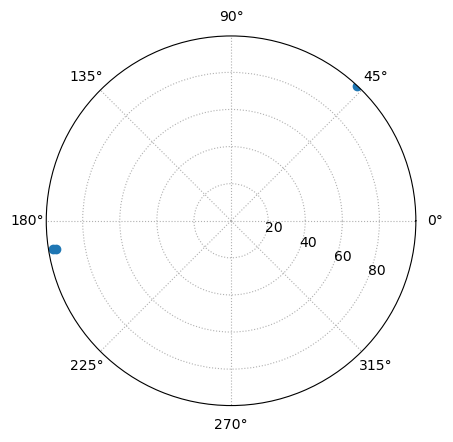

In [75]:
# bring in the figure

# make radians go from 0 to 360 so we can plot bearing without modifying it

#distance_grid = np.arange(0, 1, 0.1) #in km
#rads = np.arange(0, 2*np.pi)
# trying to plot two plots
# fig = plt.figure(2)
# n_rows, n_cols = 2, 2
# fig, ax = plt.subplots(n_rows, n_cols, squeeze=False, figsize=(13,13), subplot_kw={'projection': 'polar'})
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
#ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearing_list
r = dfs3

#ax[1,0].scatter(theta, r)
ax.scatter(theta, r)

plt.show()

Success!! Now to do it for all of the vads with the storm motion set as the 0 axis.

In [52]:
# get the storm motion (in degrees)
# Code from Alex S and Josh O

#Calculate storm motion 

decimalhour=[]
decimalsec=[]
for i in np.arange(0,len(storm_location),1):
    (h, m, s) = storm_location.loc[i].Time.split(':')
    result = int(h) + int(m)/60 + int(s)/3600
    result1 = int(h) * 3600 + int(m) * 60 + int(s)
    decimalsec.append(result1)
    decimalhour.append(result)
storm_location['decimalhour']=decimalhour
storm_location['decimalsec']=decimalsec
storm_decimalsec=storm_location.decimalsec.astype(float)


from math import sin, cos, sqrt, atan2, radians

def calc_velocity(lat1,lon1,lat2,lon2,time1,time2):
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c * 1000 # Distance in m
    return d / (time2 - time1)

def get_bearing(lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = cos(radians(lat2)) * sin(radians(dLon))
    y = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(dLon))
    brng = np.arctan2(x,y)
    brng = (np.degrees(brng)+180) % 360
    return brng

velocity1=[]
direction1=[]
for i in np.arange(0,len(storm_location)-1,1):
    velocity = calc_velocity(storm_lat[i],storm_lon[i],
                             storm_lat[i+1],storm_lon[i],
                             storm_decimalsec[i],storm_decimalsec[i+1])
    velocity1.append(velocity)
    direction = get_bearing(storm_lat[i],storm_lon[i],
                             storm_lat[i+1],storm_lon[i+1])
    direction1.append(direction)
velocity1 = np.append([np.nan],velocity1)
direction1 = np.append([np.nan],direction1)
storm_location['storm_vel']=velocity1 #m/s
storm_location['storm_dir']=direction1 #deg

#print(velocity1)
#print(direction1)

In [53]:
# only need degrees (so the direction) of the storm
# convert to dataframe
# df for data frame so i can use pandas to drop the nan. cant average with nan in list
directiondf = pd.DataFrame(direction1)

direction_corrected = directiondf.dropna()

avg_storm_direction = np.average(direction_corrected)

print(avg_storm_direction) # avg storm direction in degrees

247.85901642897275


In [106]:
test = avg_storm_direction - 360

In [ ]:
# convert avg storm direction to radians?

In [57]:
radians_avg_storm_direction = avg_storm_direction * (np.pi/180)

In [54]:
# try to change theta location
# E is for East, where the 0 line is
# the next value is what i actually want to offset the zero axis to
ax.set_theta_zero_location('E', avg_storm_direction)

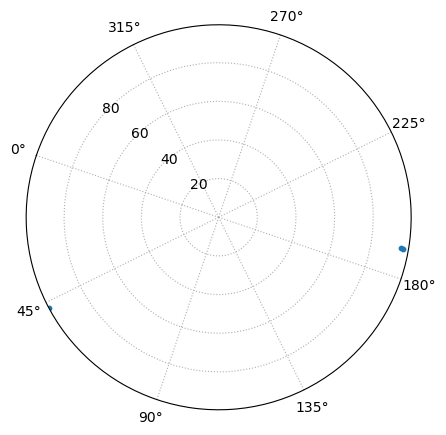

In [59]:
# bring in the figure

# make radians go from 0 to 360 so we can plot bearing without modifying it

#distance_grid = np.arange(0, 1, 0.1) #in km
#rads = np.arange(0, 2*np.pi)

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('N', avg_storm_direction)
ax.set_theta_offset(avg_storm_direction)
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearing_list
r = dfs3

ax.scatter(theta, r, s=10)

plt.show()

While it looks wack, it works, so lets actually try to plot everything on it now.

In [26]:
# check to see if our r is still here
# r = dfs (distance from storm)
#print(dfs)
#print(np.size(dfs))

In [90]:
# alright laptop... you can do this...
# get bearings of ALL VADs

bearing_list2 = []

# Code from Alex S and Josh O
# Fixing the bearing
from datetime import datetime

# gps data for first ka
ka1gps = pd.read_csv('C:/Users/julia/Desktop/Research/GPS_Ka1_20220523.txt')
ka1gps=ka1gps.astype(str)
# scan data for first ka
ka1scan = pd.read_csv('C:/Users/julia/Desktop/Research/20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])
# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska1 = sorted(glob.glob('C:/Users/julia/Desktop/Research/product_raw_ka1/*.nc'))

#print(ka1gps)

# !!! 37 is the last working index before it goes out of range !!!
# there are only 37 netcdf vad files

for thefile in (vad_fileska1[:37]):

    radar = pyart.io.read_cfradial(thefile)
    print(thefile,radar.fixed_angle['data'])
    
    # selects a column and uses it to tell program how to run through data
    
    ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]'] 
    ka1gps['datetime'] = [datetime.strptime(d,'%d%m%y%H%M%S') for d in ka1gps['ddmmyy']+ka1gps['hhmmss[UTC]']]
    beginscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amin(np.unique(radar.time['data']))
    endscanindex = ka1gps.loc[ka1gps['datetime'] == datetime.strptime(radar.time['units'],'seconds since %Y-%m-%dT%H:%M:%SZ')].index+np.amax(np.unique(radar.time['data']))
    dfscan = ka1gps.iloc[beginscanindex[0].astype(int):endscanindex[0].astype(int)]
    dfscan = dfscan.astype({'Bearing[degrees]': 'float'})

    speed = dfscan['Velocity[knots]'].astype(float).mean()
        
    #Get Bearing from deployment log or gps file
    if int(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Deployment.values[0]) != 0:
        bearing = float(ka1scan.loc[ka1scan['Datetime'] == dfscan.datetime.values[0]].Heading.values[0])
    else:
        bearing = dfscan['Bearing[degrees]'].mean()
        
    #Manual Corrections
    if bearing == 80.06703703703703:
        bearing = 190
    elif (bearing == 64.25037037037036):
        bearing = 9.980000000000002
    elif (bearing == 89.28925925925924):
        bearing = 92.6
    elif bearing == 269.9640740740741:
        bearing = 90.6
    elif bearing == 206.84615384615387:
        bearing = 149.0
    elif bearing == 263.8211111111111:
        bearing = 90.2
    
    #print('Bearing used: '+str(bearing))
    
    lat_vads = dfscan['Latitude'].astype(float)
    lon_vads = dfscan['Longitude'].astype(float)
    
    #print(lat)
    #print(lon)
    #Bearing Correction
    radar.azimuth['data']+=(bearing)%360
    #print(bearing)
    
    # add all bearings from loop to list
    bearing_list2.append(bearing)
    
print(bearing_list2)

C:/Users/julia/Desktop/Research/product_raw_ka1\Ka12205232.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205632.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205701.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205730.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205759.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205828.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205857.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205926.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523205955.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523221718.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Research/product_raw_ka1\Ka1220523222551.nc [37.001953 45.      ]
C:/Users/julia/Desktop/Res

**The bearing size does not match the size of the distances from the storm array! There are 64 in the distance from storm array but only 37 for the bearing!** Points will thus be missing from the graph, especially the closer ones!

Why is there only 37 indeces for the bearing? when attempting to run the vad list in its entirety, instead of finishing at 37 indeces, after 37 there is an error that something is out of bounds for axis 0 or something. are there less bearing calculations than vads? were some cut out for quality control?

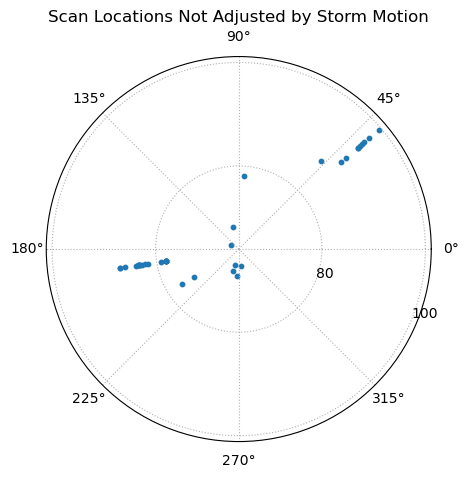

In [109]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Scan Locations Not Adjusted by Storm Motion")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearing_list2
r = dfs_new2[:37]

ax.scatter(theta, r, s = 10) # s changes point size

plt.show()

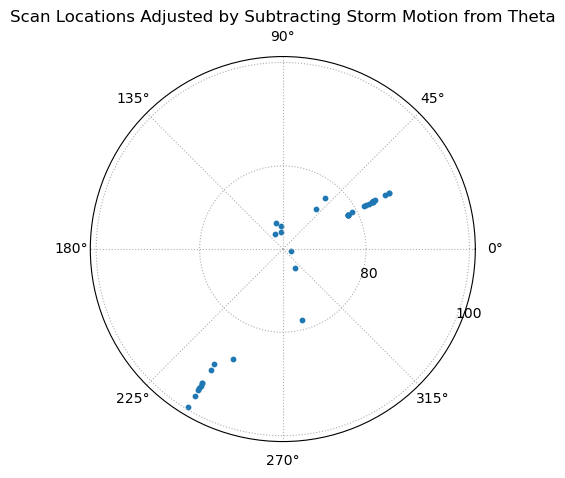

In [110]:
# bring in the figure

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Scan Locations Adjusted by Subtracting Storm Motion from Theta")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearing_list2
adjusted_theta = bearing_list2 - avg_storm_direction
r = dfs_new2[:37]

ax.scatter(adjusted_theta, r, s = 10) # s changes point size

plt.show()

Plot the areas near the inflow

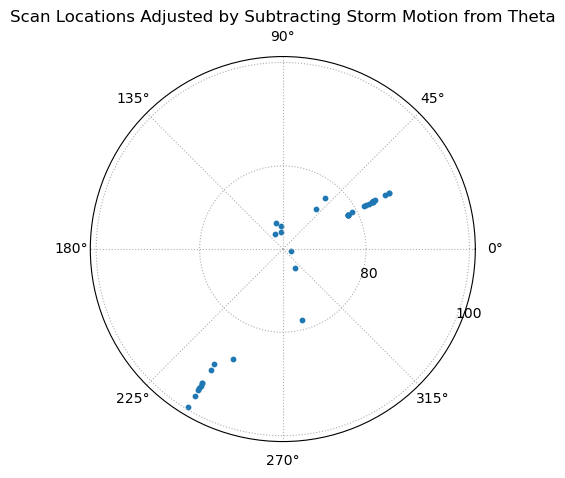

In [103]:
# bring in the figure

#distance_grid = np.arange(40,120,20)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
ax.set_rticks(distance_grid)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
#ax.set_theta_offset(avg_storm_direction)
ax.set_title("Scan Locations Adjusted by Subtracting Storm Motion from Theta")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearing_list2
adjusted_theta = bearing_list2 - avg_storm_direction
r = dfs_new2[:37]
#line_1
ax.scatter(adjusted_theta, r, s = 10) # s changes point size

plt.show()

Ask chris about which way is best to rotate graph; via set_theta_zero_location with North, South, East, and West involved in some way, or just set_theta_offset with only the storm direction involved
What is the optimal distance away from storm?
Why are meters so close (i.e. 0.5m?) are the units not actually meters or did I miscalculate?

For morton: around 0 to 60 km

In [29]:
# is distance in ka1 scan log the distance from the storm?? what does distance mean?

ka1gps = pd.read_csv('C:/Users/julia/Desktop/Research/GPS_Ka1_20220523.txt')
# scan data for first ka
ka1scan = pd.read_csv('C:/Users/julia/Desktop/Research/20220523_Ka1_scan_log.txt', dtype=str,
                     parse_dates=[0])

# dealiased vad data created from VADS.ipynb for ka 1, but not bearing corrected
vad_fileska1 = sorted(glob.glob('C:/Users/julia/Desktop/Research/product_raw_ka1/*.nc'))

print(ka1scan.Distance)

0                      0.0
1        633.4661352371563
2        637.7769397063854
3        574.6323801955193
4       176.25245578186426
              ...         
302    0.32635385310166426
303     0.4600264669008628
304     0.8827209367044998
305    0.31310701283426595
306     0.2083974074685191
Name: Distance, Length: 307, dtype: object


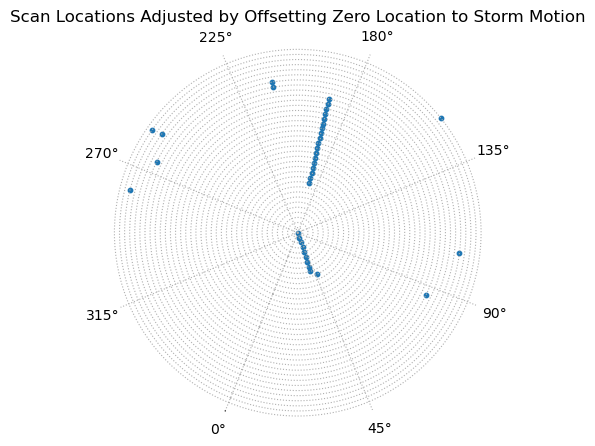

In [96]:
# bring in the figure

#distance_grid = np.arange(0, 200) #in km
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection = 'polar')
ax.set_rmax(2)
#ax.set_rticks(distance_grid)
#ax.get_gridlines(distance_grid)
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.set_yticklabels([])
ax.grid(True, linestyle = ':') # makes grid lines dotted
#ax.set_theta_zero_location('W', avg_storm_direction) # what is the N, S, E, W good for?
ax.set_theta_offset(radians_avg_storm_direction)
ax.set_title("Scan Locations Adjusted by Offsetting Zero Location to Storm Motion")
ax.plot()

# now that we have the figure set up, we can plot on it
# r --> great circle distance from lat and lon of storm to lat and lon of vehicle
# theta --> corrected bearing
# in polar plots the order of plotting is (theta, r)
theta = bearing_list2
r = ka1scan.Distance[0:37]

# something with the scatter plot im assuming creates a new tick for each point
# want to create ticks where the points plot around/on
ax.scatter(theta, r, s = 10) # s changes point size

plt.show()

manually calculate one single plot to see where it plots (azimuth, range, great circle calculation)

check rotation of graph, points should be located in lower right quandrant

Look at hodographs to derive storm motion??